In [131]:
import pandas as pd
import numpy as np
import json
from random import sample
from datetime import datetime
from nltk.corpus import stopwords
from string import punctuation
from zipfile import ZipFile
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.text import TSNEVisualizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

#### we have tweets downloaded in a file where every line is a separate tweet
#### the files are in a zip for smaller storage. first we read the tweets into a list

In [20]:
tweets=[]
with ZipFile('tweets_tsla_en.zip') as z:
    with open('tweets_tsla_en.txt',encoding='utf-8') as input_file:
        for line in input_file:
            tweets.append(json.loads(line))
print(len(tweets))

18171


In [22]:
tweet_df=pd.DataFrame({
    'ts':[datetime.strptime(t['created_at'],'%a %b %d %H:%M:%S %z %Y') for t in tweets],
    'text':[t['full_text'] for t in tweets],
    'uid':[str(t['user']['id']) for t in tweets],
    'followers':[t['user']['followers_count'] for t in tweets],
    'user_description':[t['user']['description'] for t in tweets],
    'retweets':[t['retweet_count'] for t in tweets],
})
tweet_text=tweet_df['text'].tolist()
print(tweet_df.shape)
tweet_df.head()

(18171, 6)


,ts,text,uid,followers,user_description,retweets
0,2019-03-24 16:13:15+00:00,I guess this is why #Tesla doesn't pay to adve...,1062169818504278017,65,"Time traveller from the future, came back to m...",0
1,2019-03-24 16:10:45+00:00,@SnazzyQ I wouldn't hate $tsla if they didn't ...,1085955094254735361,17,Sr Manufacturing Eng for a very well known tec...,0
2,2019-03-24 16:10:30+00:00,https://t.co/s6lVxNDe7C &lt; My Review of The ...,938499974467411968,82,Sharing the profits and the stock market love!,0
3,2019-03-24 16:10:16+00:00,@anonyx10 @jasonsbishop @lexfridman He also ta...,64954895,1057,I have it on good authority that I'm a limp-wr...,0
4,2019-03-24 16:09:26+00:00,Careful @elonmusk the @SEC_News might file an...,270599617,111,"Musings on IP Law, Sports, & Tech. \nAlso find...",0


#### for the tweets, extract tokens

In [85]:
stop_words=list(set(stopwords.words('english')))
for item in punctuation:
    stop_words.append(item)
    
def my_tokenizer(in_string):
    """
    Convert `in_string` of text to a list of tokens using NLTK's TweetTokenizer
    """
    # reasonable, but adjustable tokenizer settings
    tokenizer = TweetTokenizer(preserve_case=False,
                               reduce_len=True,
                               strip_handles=False)
    lemmatizer = WordNetLemmatizer()
    tweets = lemmatizer.lemmatize(in_string)
    in_string=in_string.replace("$","#_")
    tokens = tokenizer.tokenize(in_string)
    return_tokens=[]
    for token in tokens:
        if 'http://' not in token and 'https://' not in token and 'tsla' not in token: return_tokens.append(token.replace("#_","$"))
    return return_tokens

In [87]:
tweet=sample(tweet_text,1)
print(tweet[0])
print(my_tokenizer(tweet[0]))

@ClarkDennisM @GregKable @Porsche Market is not there yet. $TSLA sold cars for 3 years only to deliver them in 10 months. @tesla is desperately in search of a business model. $TSLAQ
['@clarkdennism', '@gregkable', '@porsche', 'market', 'is', 'not', 'there', 'yet', '.', 'sold', 'cars', 'for', '3', 'years', 'only', 'to', 'deliver', 'them', 'in', '10', 'months', '.', '@tesla', 'is', 'desperately', 'in', 'search', 'of', 'a', 'business', 'model', '.']


In [88]:
vec=TfidfVectorizer(tokenizer=my_tokenizer,stop_words=stop_words,max_features=1000)
matrix=vec.fit_transform(tweet_text)
matrix

<18171x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 152833 stored elements in Compressed Sparse Row format>

In [89]:
(pd.DataFrame(matrix[:10].todense(),columns=[x for x in vec.get_feature_names()])
 # experiment by choosing any range of feature indices (alphabetical order)
 .iloc[:,330:430])

,course,court,cover,cramer,crash,crazy,credit,criminal,cult,current,...,fast,feel,file,filing,finally,financial,find,fine,fire,first
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.371254,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


fitting model for 2 clusters
fitting model for 50 clusters
fitting model for 200 clusters
fitting model for 500 clusters


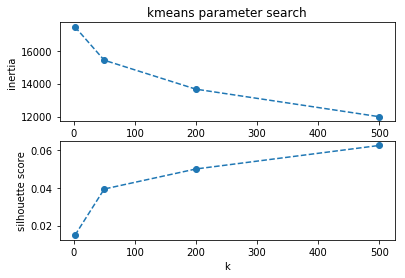

In [90]:
# compare a broad range of ks to start
ks = [2, 50, 200, 500]


# track a couple of metrics
sil_scores = []
inertias = []

# fit the models, save the evaluation metrics from each run
for k in ks:
    print('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1)
    model.fit(matrix)
    labels = model.labels_
    sil_scores.append(silhouette_score(matrix, labels))
    inertias.append(model.inertia_)

# plot the quality metrics for inspection
fig, ax = plt.subplots(2, 1, sharex=True)

plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

plt.subplot(212)
plt.plot(ks, sil_scores, 'o--')
plt.ylabel('silhouette score')
plt.xlabel('k');

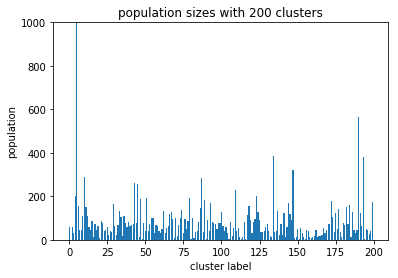

In [91]:
best_k = 20

km_model = KMeans(n_clusters=best_k, n_jobs=-1)
km_model.fit(matrix)

plt.bar(range(len(set(km_model.labels_))), np.bincount(km_model.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('population sizes with {} clusters'.format(best_k));

# truncate y axis to see the rest better
# (comment out to see the peak value for the largest cluster)
plt.ylim(0,1000);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

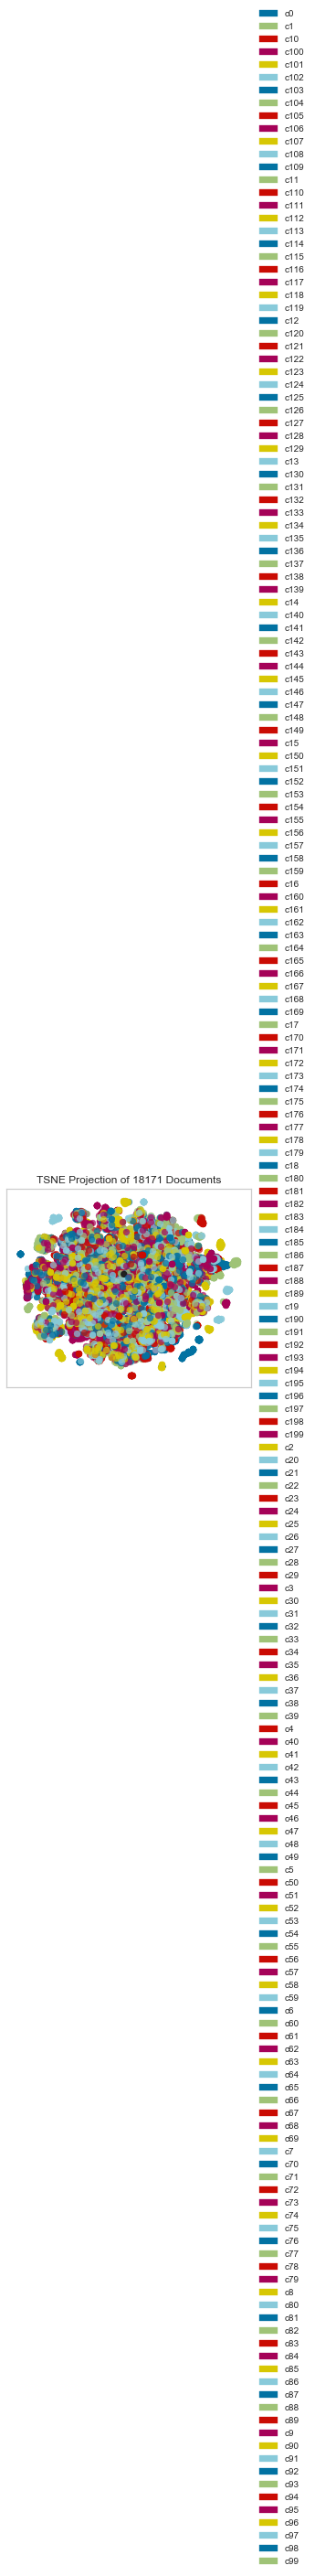

In [106]:
tsne = TSNEVisualizer()
tsne.fit(matrix, ["c{}".format(c) for c in km_model.labels_])
tsne.poof()

In [92]:
def strongest_features(model, vectorizer, topk=10):
    """
    Helper function to display a simple text representation of the top-k most
    important features in our fit model and vectorizer.

    model: sklearn model
    vectorizer: sklearn vectorizer
    topk: k numbers of words to get per cluster

    """
    # these parts are model-independent
    m_name = model.__class__.__name__
    features = vectorizer.get_feature_names()
    # different calculations per model type
    if m_name is 'KMeans':
        relevant_labels = list(set(model.labels_))
        centroids = model.cluster_centers_.argsort()[:,::-1]
        for this_label in relevant_labels:
            print('Cluster {}:'.format(this_label), end='')
            for ind in centroids[this_label, :topk]:
                print(' {}'.format(features[ind]), end='')
            print()
    elif m_name is 'HDBSCAN':
        # ignore noise labels
        relevant_labels = [ x for x in set(model.labels_) if x >= 0 ]
        for this_label in relevant_labels:
            matching_rows = np.where(hdbs.labels_ == this_label)[0]
            coeff_sums = np.sum(bio_matrix[matching_rows], axis=0).A1
            sorted_coeff_idxs = np.argsort(coeff_sums)[::-1]
            print('Cluster {}: '.format(this_label), end='')
            for idx in sorted_coeff_idxs[:topk]:
                print('{} '.format(features[idx]), end='')
            print()
    else:
        raise NotImplementedError('This helper method currently only supports KMeans and HDBSCAN models')

In [93]:
strongest_features(km_model, vec, topk=15)

Cluster 0: — opening things car 10 model know need revealed important here's tesla ever he's still
Cluster 1: sec @zerohedge gone fine account ’ move anyone believe let already judge twitter long musk
Cluster 2: seen i've never model ’ yet anyone one tesla new ever well business many lot
Cluster 3: $avgo $adbe $ulta $orcl $fb $aapl $spy $csco $goog $bidu $tgt $ibm $dis $amzn $gld
Cluster 4: model tesla x website new standard option range week reasons event red reveal first 7
Cluster 5: one would going get new company right go cash think back well next much many
Cluster 6: guides traders active try trading $gs free $googl $nvda $nflx $amzn $fb one $aapl $wynn
Cluster 7: factories reveals nevada california saw analyst tesla insider ’ markets business things ... 10 know
Cluster 8: million billion $5 10 sales $1 $nvda $nflx 1 value $aapl cost 250 tesla #trading
Cluster 9: tweets sec musk @elonmusk via tesla seeing ’ ceo material never elon #tesla back court
Cluster 10: musk elon tesla ceo 

Cluster 120: increase price 3 tesla prices orders order quarter end hit @wallstcynic ... bod what's fred
Cluster 121: .. ... one ’ lol @gwestr market musk car tesla see think made money ev
Cluster 122: buying shares retail anyone stock i'm robinhood would 🤣 #tesla buy car someone ’ end
Cluster 123: time ’ every ... one first back elon get week car think next like market
Cluster 124: sure i'm pretty ’ make ... @elonmusk one elon get thing time day tesla stock
Cluster 125: close today ... robinhood market 2019 previous change march holding since look would deal week
Cluster 126: $bhc $hlf $jnj $iep $mcd $tst $agn $sbux $brk $pep $wmt $esrx $ko $f $tgt
Cluster 127: world real people #tesla help stop please via ’ think know get we're #gold ...
Cluster 128: stay friends short read think ... tesla @jimcramer @elonmusk ’ let one could love far
Cluster 129: crazy ’ numbers ... @elonmusk stuff like customers sales believe last sale elon market one
Cluster 130: gets elon ’ tesla @elonmusk play y

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


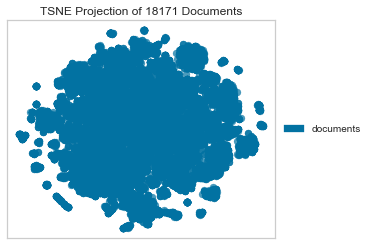

In [97]:
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer(labels=["documents"])
tsne.fit(matrix)
tsne.poof()

In [ ]:
tsne = TSNE(n_components=2)
matrix_2d = tsne.fit_transform(matrix.todense())


In [105]:
temp_df=tweet_df[['followers','retweets']].copy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(temp_df)
transformed_data=scaler.transform(temp_df)

c:\users\tihor\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\tihor\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """


array([[-0.13862182, -0.06026823],
       [-0.14051269, -0.06026823],
       [-0.13795214, -0.06026823],
       ...,
       [-0.13314618, -0.06026823],
       [-0.04884499, -0.06026823],
       [-0.13432797, -0.06026823]])

fitting model for 30 clusters
fitting model for 40 clusters
fitting model for 50 clusters
fitting model for 60 clusters
fitting model for 70 clusters
fitting model for 80 clusters


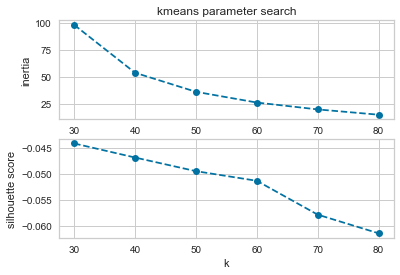

In [108]:
# compare a broad range of ks to start
ks = [30,40, 50, 60, 70,80]

# track a couple of metrics
sil_scores = []
inertias = []

# fit the models, save the evaluation metrics from each run
for k in ks:
    print('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1)
    model.fit(transformed_data)
    labels = model.labels_
    sil_scores.append(silhouette_score(matrix, labels))
    inertias.append(model.inertia_)

# plot the quality metrics for inspection
fig, ax = plt.subplots(2, 1, sharex=True)

plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

plt.subplot(212)
plt.plot(ks, sil_scores, 'o--')
plt.ylabel('silhouette score')
plt.xlabel('k');

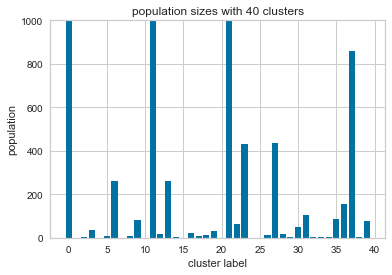

In [110]:
best_k = 40

km_model = KMeans(n_clusters=best_k, n_jobs=-1)
km_model.fit(transformed_data)

plt.bar(range(len(set(km_model.labels_))), np.bincount(km_model.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('population sizes with {} clusters'.format(best_k));

# truncate y axis to see the rest better
# (comment out to see the peak value for the largest cluster)
plt.ylim(0,1000);

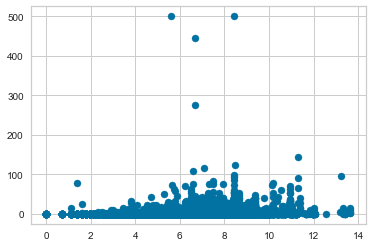

In [128]:
plt.scatter(tweet_df['followers'].apply(lambda x:np.log(x)),tweet_df['retweets'].apply(lambda x:x if x<500 else 500), s=50);

In [124]:
zz=tweet_df[tweet_df['retweets']>1000]
)

,ts,text,uid,followers,user_description,retweets
13069,2019-03-17 21:52:49+00:00,"People are buying Tesla’s, in their Tesla’s. ...",22400492,273,"Geek, British, elitist shape thrower. Amateur ...",2928
